In [1]:
from twitch import commons
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn import cross_validation
from sklearn import preprocessing
import numpy as np
import re

from nltk.corpus import webtext
from nltk.corpus import nps_chat

%pylab inline

import matplotlib.pylab as pylab

params = {'legend.fontsize': 'xx-large',
          'axes.labelsize': 'xx-large',
          'axes.titlesize': 'xx-large',
          'xtick.labelsize': 'xx-large',
          'ytick.labelsize': 'xx-large'}

pylab.rcParams.update(params)

Populating the interactive namespace from numpy and matplotlib


In [2]:
dictionary_words = {}
for x in nps_chat.words() + webtext.words():
    dictionary_words[x] = True

In [3]:
female_channels = [line.strip().split(',')[0] for line in open('../female_channels.csv', 'r')]
male_channels = [line.strip().split(',')[0] for line in open('../male_channels.csv', 'r')]

In [40]:
channel_chat_log = []
for female in female_channels:
    message = []
    with open('../../data/channel_chat_logs/cleaned/' + female + "_chat_log.csv") as f:
        for line in f:
            splits = line.split(',')
            temp = ' '.join([x for x in splits[3].split() if x in dictionary_words])
            if len(temp) > 0:
                message.append(temp)
    channel_chat_log.append(' '.join(message))

In [41]:
for male in male_channels:
    message = []
    with open('../../data/channel_chat_logs/cleaned/' + male + "_chat_log.csv") as f:
        for line in f:
            splits = line.split(',')
            temp = ' '.join([x for x in splits[3].split() if x in dictionary_words])
            if len(temp) > 0:
                message.append(temp)
    channel_chat_log.append(' '.join(message))

In [42]:
cleaned_channel_log = []
gendered_terms = ['\bhe\b', r'\bhes', r'\bshe\b', r'\bshes\b', r'\bhis\b', r'\bher\b', r'\bbro\b',
                  r'\bman\b', r'\bsir\b', r'\bdude\b', r'\bgirl\b', r'\bgirls\b', r'\blady\b',
                  r'\bgurl\b', r'\bhers\b', r'\bhisself\b', r'\bherself\b', r'\bman\b', r'\bwoman\b']
for channel_log in channel_chat_log:
    for temp in gendered_terms:
        channel_log = re.sub(temp, '', channel_log)
    cleaned_channel_log.append(channel_log)

In [43]:
target_y = np.concatenate((np.ones(200), np.zeros(200)), axis=0)

In [44]:
tf = TfidfVectorizer(analyzer='word', max_features=100000, stop_words = 'english')

In [45]:
x = tf.fit_transform(cleaned_channel_log)

In [46]:
x = preprocessing.normalize(x)
feature_names = tf.get_feature_names()

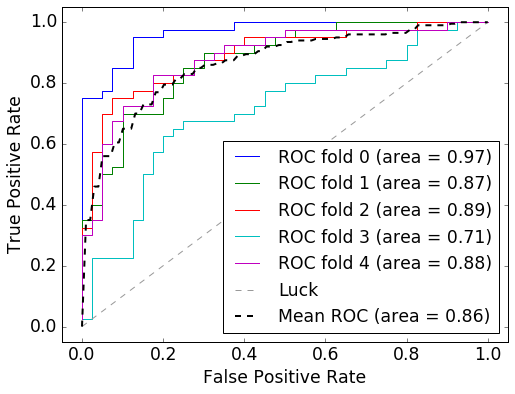

Accuracy: 0.80 (+/- 0.11)


In [47]:
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 8
fig_size[1] = 6
plt.rcParams["figure.figsize"] = fig_size

clf,coef,_ = commons.build_lr_classification_model_cv(x, target_y, 5)

In [48]:
print('Female words : ' + ', '.join([feature_names[i] for i in coef[0].argsort()[-25:][::-1]]))
print('')
print('Male words : ' + ', '.join([feature_names[i] for i in (- coef[0]).argsort()[-25:][::-1]]))

Female words : hi, song, boobs, im, hello, cat, que, love, omg, la, kitty, cute, dont, beautiful, tits, hair, bye, ally, night, like, el, follow, amy, look, hot

Male words : game, got, sup, does, max, yo, did, run, level, good, spam, just, mark, shadow, red, think, team, chief, points, sp, sketch, pm, monster, mic, use


## Clustering the document vectors

In [49]:
x_dense = x.todense().tolist()
cluster_xy_vectors = commons.reduce_dim(x_dense, 'tsne')

[t-SNE] Computing pairwise distances...
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Computed conditional probabilities for sample 400 / 400
[t-SNE] Mean sigma: 0.159335
[t-SNE] Iteration 25: error = 1.0999339, gradient norm = 0.0211503
[t-SNE] Iteration 50: error = 1.0731075, gradient norm = 0.0179582
[t-SNE] Iteration 75: error = 0.8769017, gradient norm = 0.0119276
[t-SNE] Iteration 100: error = 0.9793250, gradient norm = 0.0152488
[t-SNE] Error after 100 iterations with early exaggeration: 0.979325
[t-SNE] Iteration 125: error = 0.8194707, gradient norm = 0.0082470
[t-SNE] Iteration 150: error = 0.8901414, gradient norm = 0.0118373
[t-SNE] Iteration 175: error = 1.0213697, gradient norm = 0.0154077
[t-SNE] Iteration 175: did not make any progress during the last 30 episodes. Finished.
[t-SNE] Error after 175 iterations: 1.021370


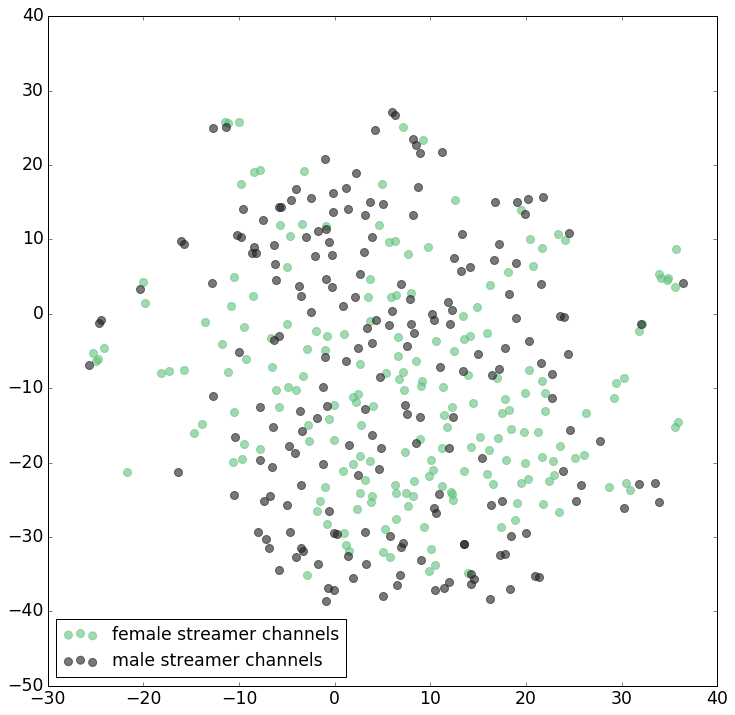

In [50]:
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 12
fig_size[1] = 12
plt.rcParams["figure.figsize"] = fig_size

plt.scatter([x[0] for i,x in enumerate(cluster_xy_vectors) if target_y[i] == 1],
            [y[1] for i,y in enumerate(cluster_xy_vectors) if target_y[i] == 1],
            s=64, color='#63c17e' , lw=1, label='female streamer channels', alpha=0.6)
 
#facecolors='none', edgecolors='#8856a7'
plt.scatter([x[0] for i,x in enumerate(cluster_xy_vectors) if target_y[i] == 0],
            [y[1] for i,y in enumerate(cluster_xy_vectors) if target_y[i] == 0],
            s=64, color='#1F1F1F', lw=1, label='male streamer channels', alpha=0.6)


plt.legend(loc='lower left')
savefig('channel_clusters_bow.png')

In [51]:
len(cleaned_channel_log)

400

In [54]:
"sp" in dictionary_words

True